# Model Evaluation

Evaluate all wind speed prediction models using the evaluation framework.


In [5]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from eval_helpers import evaluate, plot_predictions, compare
from data.data_helpers import get_dataframe
from models import (
    PersistenceModel,
    LinearRegressionModel,
    RandomForestModel,
    XGBoostModel,
    MLPModel,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Load Data


In [6]:
# Load data
df = get_dataframe()
df = df.dropna(subset=["target_next_hour"])

# Temporal split: 2018-2019 for training, 2020 for testing
train_df = df[df["datetime"] < "2020-01-01"].copy()
test_df = df[df["datetime"] >= "2020-01-01"].copy()

print(f"Training set: {len(train_df):,} samples")
print(f"Test set: {len(test_df):,} samples")

# Store datetime for plotting
test_datetime = test_df["datetime"].copy()


c:\Users\Michel\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2025-12-06 17:52:27,494 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


Skipping existing file C:\Users\Michel\OneDrive\Projects\cis5200-project\data\era5_tehachapi_2018_H1.nc
Skipping existing file C:\Users\Michel\OneDrive\Projects\cis5200-project\data\era5_tehachapi_2018_H2.nc
Skipping existing file C:\Users\Michel\OneDrive\Projects\cis5200-project\data\era5_tehachapi_2019_H1.nc
Skipping existing file C:\Users\Michel\OneDrive\Projects\cis5200-project\data\era5_tehachapi_2019_H2.nc
Skipping existing file C:\Users\Michel\OneDrive\Projects\cis5200-project\data\era5_tehachapi_2020_H1.nc
Skipping existing file C:\Users\Michel\OneDrive\Projects\cis5200-project\data\era5_tehachapi_2020_H2.nc
Training set: 17,520 samples
Test set: 8,783 samples


## Evaluate Models

Evaluate each model and collect results.



Training PersistenceBaseline model...


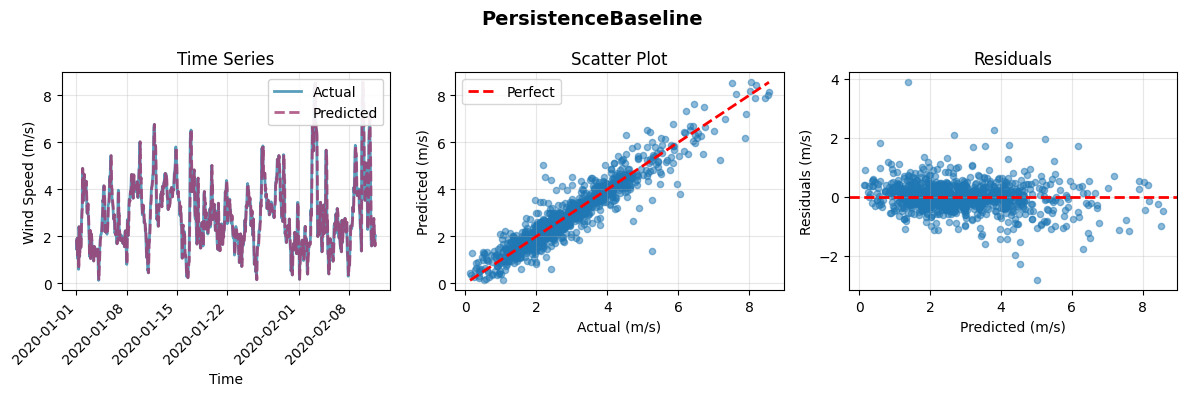


Training LinearRegression model...


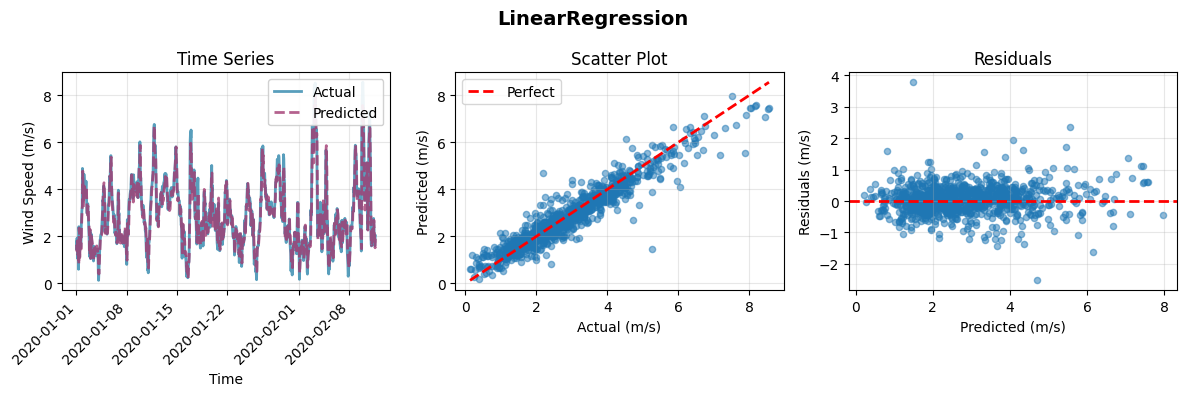


Training RandomForest model...


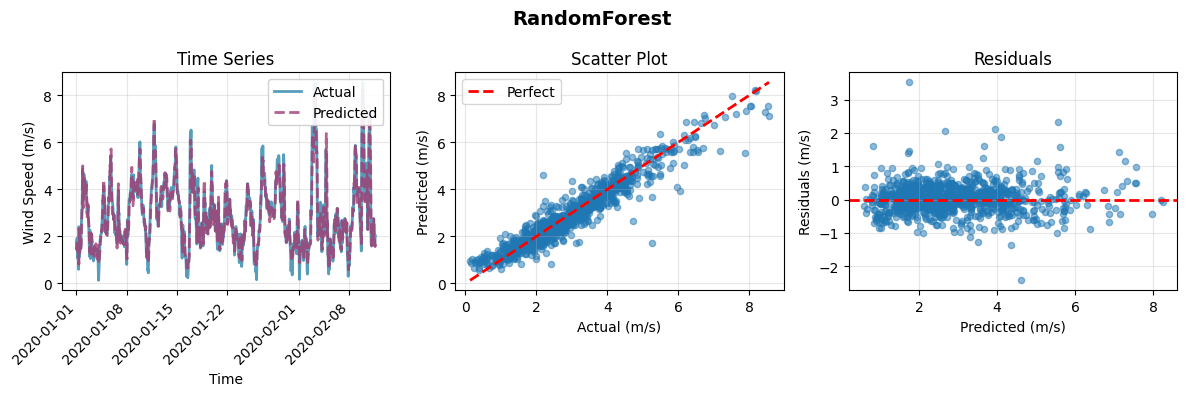


Training XGBoost model...


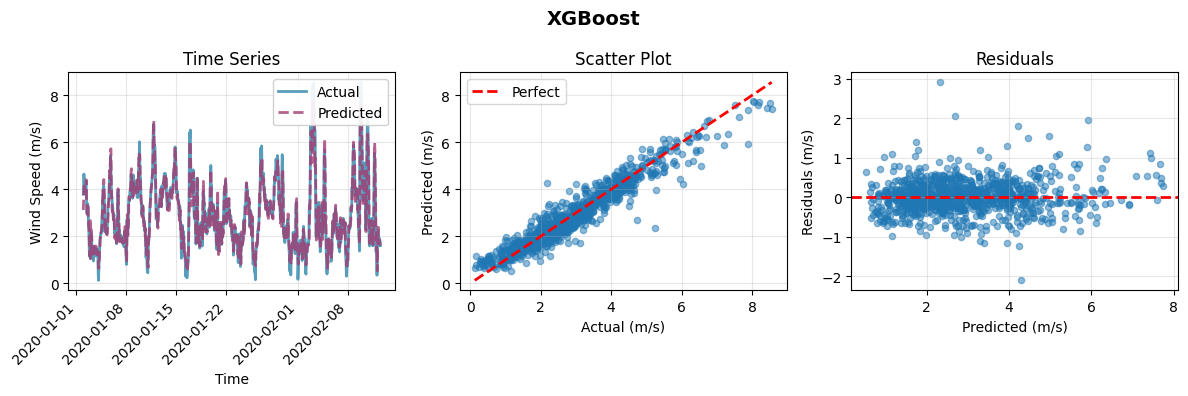


Training MLP model...
Training MLP on cuda with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

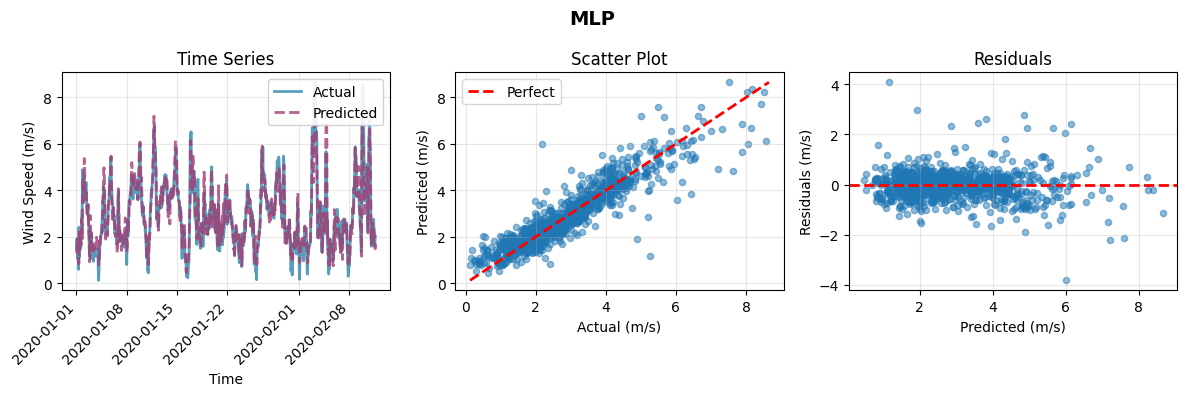

In [7]:
# Collect results from all models
results = []

# Precompute common data views so each model can grab what it needs
DROP_COLS = ['datetime', 'target_next_hour']
X_train_full = train_df.copy()
X_test_full = test_df.copy()
X_train_features = train_df.drop(columns=DROP_COLS).copy()
X_test_features = test_df.drop(columns=DROP_COLS).copy()
y_train = train_df['target_next_hour']
y_test = test_df['target_next_hour']

data_views = {
    'full': (X_train_full, y_train, X_test_full, y_test),
    'features': (X_train_features, y_train, X_test_features, y_test),
}

model_configs = [
    {'name': 'PersistenceBaseline', 'constructor': PersistenceModel, 'data_view': 'full'},
    {'name': 'LinearRegression', 'constructor': LinearRegressionModel, 'data_view': 'features'},
    {'name': 'RandomForest', 'constructor': RandomForestModel, 'data_view': 'features'},
    {'name': 'XGBoost', 'constructor': XGBoostModel, 'data_view': 'full', 'mask_nan_predictions': True},
    {'name': 'MLP', 'constructor': MLPModel, 'data_view': 'features'},
]

for cfg in model_configs:
    print(f"\nTraining {cfg['name']} model...")
    constructor = cfg['constructor']
    params = cfg.get('params', {})
    model = constructor(**params)

    X_train_sel, y_train_sel, X_test_sel, y_test_sel = data_views[cfg['data_view']]
    result = evaluate(
        model,
        X_train_sel,
        y_train_sel,
        X_test_sel,
        y_test_sel,
        model_name=cfg['name'],
    )
    results.append(result)

    preds = result['predictions']
    y_plot = y_test_sel
    datetime_plot = test_datetime

    if cfg.get('mask_nan_predictions'):
        valid_mask = ~np.isnan(preds)
        if valid_mask.sum() == 0:
            print(f"Skipping plot for {cfg['name']} (all predictions NaN).")
            continue
        preds = preds[valid_mask]
        y_plot = y_plot.iloc[valid_mask] if hasattr(y_plot, 'iloc') else y_plot[valid_mask]
        datetime_plot = (
            test_datetime.iloc[valid_mask]
            if hasattr(test_datetime, 'iloc')
            else test_datetime[valid_mask]
        )

    plot_predictions(y_plot, preds, model_name=cfg['name'], datetime_index=datetime_plot)
    plt.show()


## Compare All Models



MODEL COMPARISON
              Model  MAE (m/s)  RMSE (m/s)       R²  Asymmetric MSE
            XGBoost   0.234872    0.335001 0.942640        0.170987
       RandomForest   0.251329    0.360330 0.933627        0.201054
   LinearRegression   0.280173    0.392446 0.921268        0.236544
                MLP   0.291701    0.421840 0.909032        0.249595
PersistenceBaseline   0.315406    0.452842 0.895170        0.308777


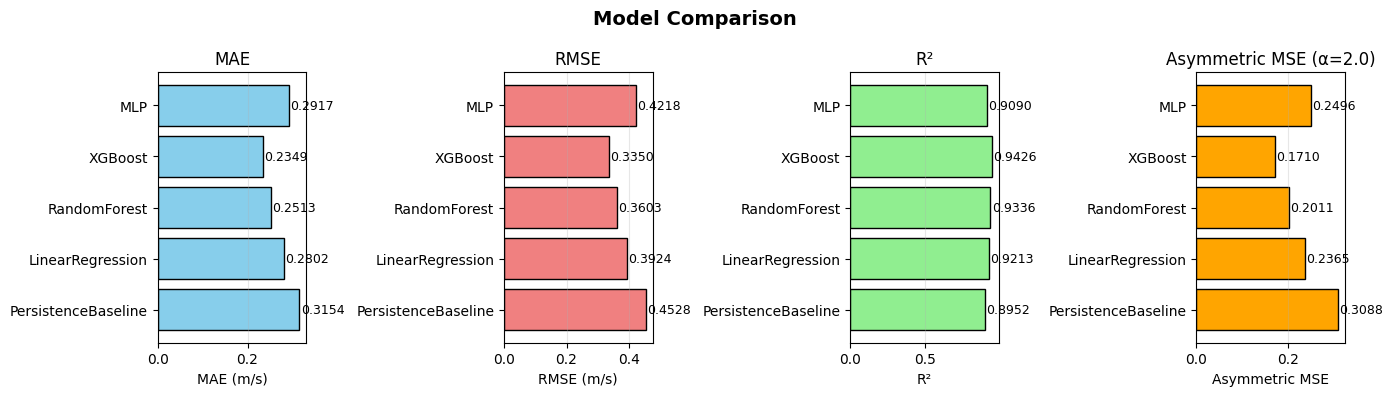

In [8]:
# Compare all models
scorecard = compare(results, plot=True)
